# Regression Model for Kaggle Tabular Playground Series 2021 Jan Using Python and Scikit-learn
### David Lowe
### May 17, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Series 2021 Jan dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have been hosting playground-style competitions on Kaggle with fun but less complex, tabular datasets. These competitions will be great for people looking for something between the Titanic Getting Started competition and a Featured competition.

ANALYSIS: The average performance of the machine learning algorithms achieved an RMSE benchmark of 0.5276 using the training dataset. We selected ElasticNet and Extra Trees to perform the tuning exercises. After a series of tuning trials, the refined Extra Trees model processed the training dataset with a final RMSE score of 0.4949. When we apply the last model to Kaggle's test dataset, the model achieved an RMSE score of 0.7038.

CONCLUSION: In this iteration, the Extra Trees model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground Series 2021 Jan Data Set

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-jan-2021

One potential source of performance benchmarks: https://www.kaggle.com/c/tabular-playground-series-jan-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.25

# Set the number of folds for cross validation
N_FOLDS = 10

# Set various default modeling parameters
SCORING_METRIC = 'neg_mean_squared_error'

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

In [8]:
# Set up the parent directory location for loading the dotenv files
# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [11]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jan/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


In [12]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
 3   cont3   300000 non-null  float64
 4   cont4   300000 non-null  float64
 5   cont5   300000 non-null  float64
 6   cont6   300000 non-null  float64
 7   cont7   300000 non-null  float64
 8   cont8   300000 non-null  float64
 9   cont9   300000 non-null  float64
 10  cont10  300000 non-null  float64
 11  cont11  300000 non-null  float64
 12  cont12  300000 non-null  float64
 13  cont13  300000 non-null  float64
 14  cont14  300000 non-null  float64
 15  target  300000 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 36.6 MB


In [13]:
print(df_dataset_import.describe())

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,249825.145857,0.506873,0.497898,0.521557,0.515683,0.502022,0.526515,0.487890,0.525163,0.459857,0.520532,0.483926,0.506877,0.553442,0.503713,7.905661
std,144476.732562,0.203976,0.228159,0.200770,0.233035,0.220701,0.217909,0.181096,0.216221,0.196685,0.201854,0.220082,0.218947,0.229730,0.208238,0.733071
min,1.000000,-0.082263,-0.031397,0.020967,0.152761,0.276377,0.066166,-0.097666,0.217260,-0.240604,-0.085046,0.083277,0.088635,0.029950,0.166367,0.000000
25%,124656.500000,0.343078,0.319170,0.344096,0.294935,0.284108,0.356163,0.346600,0.341486,0.330832,0.375465,0.300474,0.310166,0.350472,0.308673,7.329367
50%,249738.500000,0.484005,0.553209,0.551471,0.482880,0.451733,0.470988,0.466825,0.483460,0.416843,0.458877,0.441916,0.486599,0.487707,0.431845,7.940571
75%,374836.250000,0.643789,0.731263,0.648315,0.748705,0.670660,0.694043,0.581292,0.685250,0.575041,0.700292,0.679128,0.694453,0.768479,0.712653,8.470084
max,499999.000000,1.016227,0.859697,1.006955,1.010402,1.034261,1.043858,1.066167,1.024427,1.004114,1.199951,1.022620,1.049025,0.977845,0.868506,10.267569


In [14]:
df_dataset_import.isnull().sum()

id        0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
cont14    0
target    0
dtype: int64

In [15]:
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [16]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'target': 'targetVar'})

# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,targetVar
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


In [17]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cont1      300000 non-null  float64
 1   cont2      300000 non-null  float64
 2   cont3      300000 non-null  float64
 3   cont4      300000 non-null  float64
 4   cont5      300000 non-null  float64
 5   cont6      300000 non-null  float64
 6   cont7      300000 non-null  float64
 7   cont8      300000 non-null  float64
 8   cont9      300000 non-null  float64
 9   cont10     300000 non-null  float64
 10  cont11     300000 non-null  float64
 11  cont12     300000 non-null  float64
 12  cont13     300000 non-null  float64
 13  cont14     300000 non-null  float64
 14  targetVar  300000 non-null  float64
dtypes: float64(15)
memory usage: 34.3 MB


In [18]:
print(df_dataset_import.describe())

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,targetVar
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.506873,0.497898,0.521557,0.515683,0.502022,0.526515,0.487890,0.525163,0.459857,0.520532,0.483926,0.506877,0.553442,0.503713,7.905661
std,0.203976,0.228159,0.200770,0.233035,0.220701,0.217909,0.181096,0.216221,0.196685,0.201854,0.220082,0.218947,0.229730,0.208238,0.733071
min,-0.082263,-0.031397,0.020967,0.152761,0.276377,0.066166,-0.097666,0.217260,-0.240604,-0.085046,0.083277,0.088635,0.029950,0.166367,0.000000
25%,0.343078,0.319170,0.344096,0.294935,0.284108,0.356163,0.346600,0.341486,0.330832,0.375465,0.300474,0.310166,0.350472,0.308673,7.329367
50%,0.484005,0.553209,0.551471,0.482880,0.451733,0.470988,0.466825,0.483460,0.416843,0.458877,0.441916,0.486599,0.487707,0.431845,7.940571
75%,0.643789,0.731263,0.648315,0.748705,0.670660,0.694043,0.581292,0.685250,0.575041,0.700292,0.679128,0.694453,0.768479,0.712653,8.470084
max,1.016227,0.859697,1.006955,1.010402,1.034261,1.043858,1.066167,1.024427,1.004114,1.199951,1.022620,1.049025,0.977845,0.868506,10.267569


In [19]:
df_dataset_import.isnull().sum()

cont1        0
cont2        0
cont3        0
cont4        0
cont5        0
cont6        0
cont7        0
cont8        0
cont9        0
cont10       0
cont11       0
cont12       0
cont13       0
cont14       0
targetVar    0
dtype: int64

In [20]:
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [21]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# target_column_position variable indicates the column location of the target/class variable
# If the first column, set target_column_position to 1. If the last column, set target_column_position to total_column_count
# If (target_column_position <> 1) and (target_column_position <> total_column_count), be aware when slicing up the dataframes for visualization
target_column_position = total_column_count

In [22]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations

if target_column_position == total_column_count:
    df_features_train = df_dataset_import.iloc[:,0:total_feature_count]
    df_target_train = df_dataset_import.iloc[:,total_feature_count]
else:
    df_features_train = df_dataset_import.iloc[:,1:total_column_count]
    df_target_train = df_dataset_import.iloc[:,0]

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (300000, 15) df_features_train.shape: (300000, 14) df_target_train.shape: (300000,)


### 1.f) Set up the parameters for data visualization

In [23]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [24]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [25]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


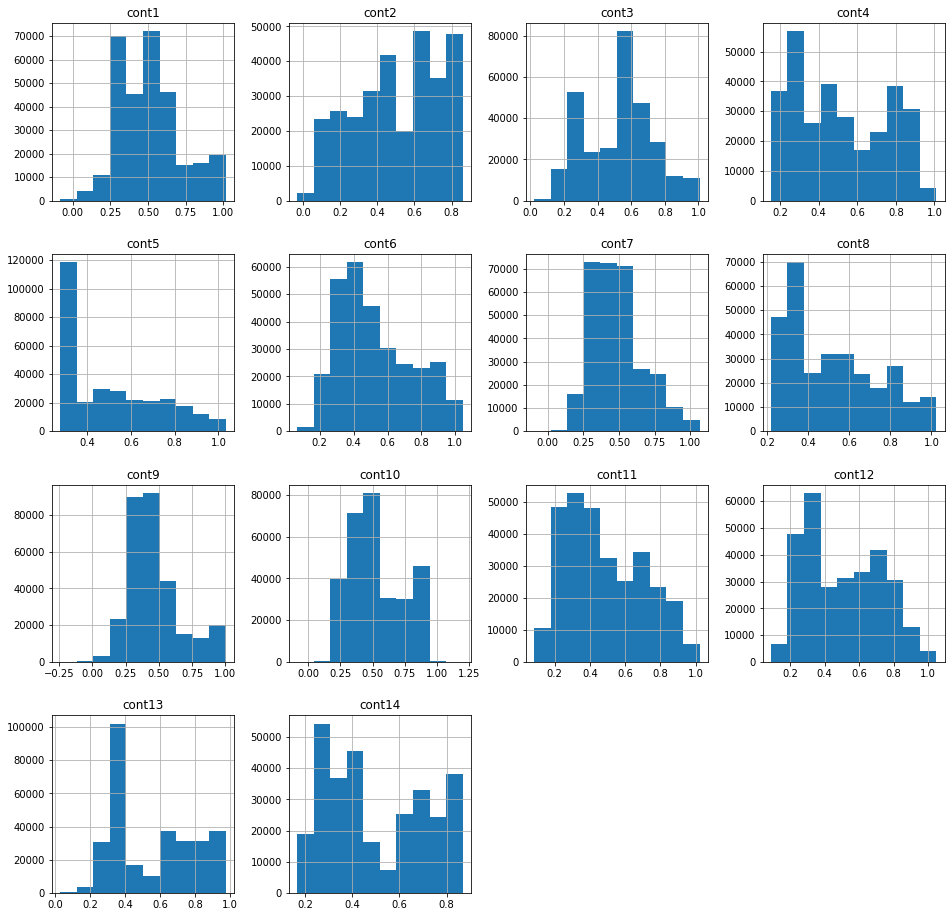

In [29]:
# Histograms for each attribute
df_features_train.hist(layout=(display_rows, display_columns))
plt.show()

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


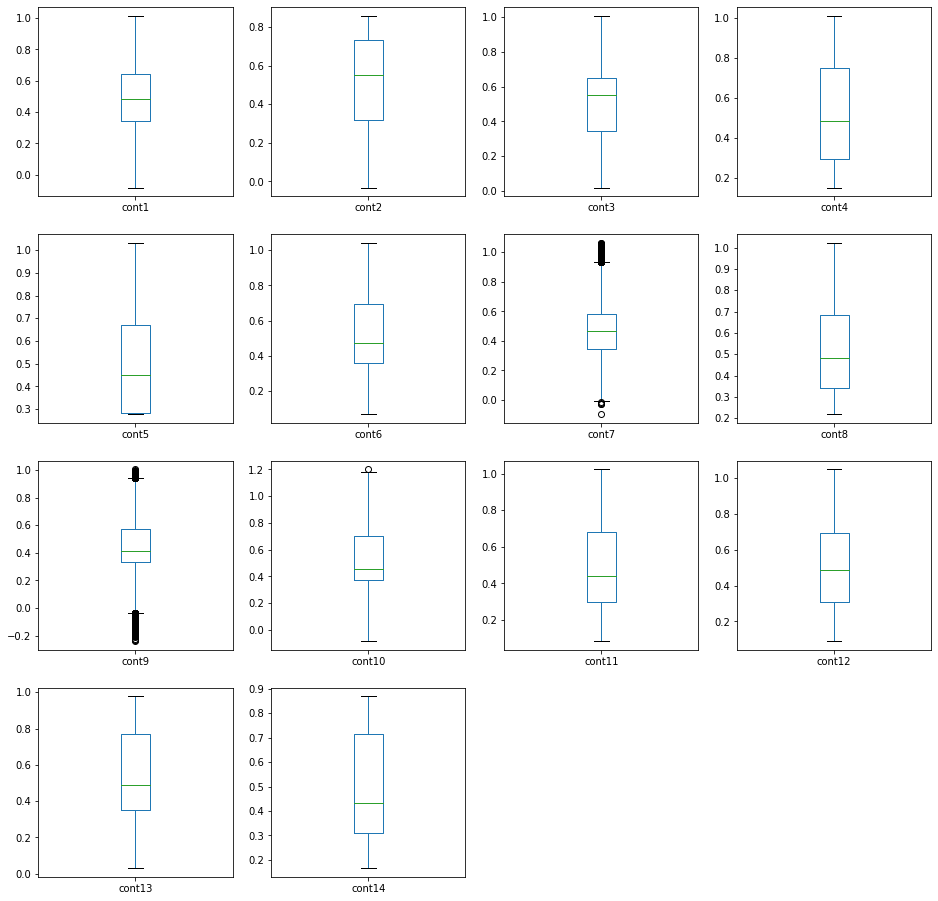

In [30]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

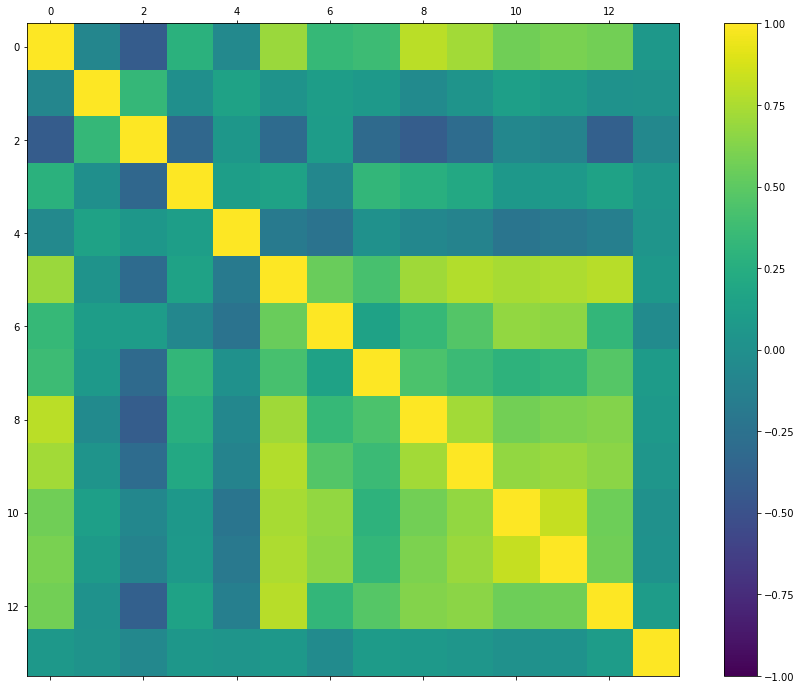

In [31]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = df_features_train.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [32]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [33]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [34]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [35]:
# Not applicable for this iteration of the project

### 3.c) Training Data Balancing

In [36]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [37]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [38]:
# Finalize the training and validation datasets for the modeling activities
array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (300000, 14) array_target_train.shape: (300000,)


In [39]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [40]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [41]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
start_time_module = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LNR', LinearRegression(n_jobs=N_JOBS)))
train_models.append(('ELN', ElasticNet(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsRegressor(n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('GBM', GradientBoostingRegressor(random_state=RNG_SEED)))

In [42]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:',np.mean(train_metrics))
print ('Average RMSE for all models is:', math.sqrt((np.mean(train_metrics)*-1)))
print ('Total training time for all models:',(datetime.now() - start_time_training))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    4.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


LNR: -0.527416 (0.002955)
LinearRegression(n_jobs=2)
Model training time: 0:00:04.973670 



[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


ELN: -0.537394 (0.003436)
ElasticNet(random_state=888)
Model training time: 0:00:01.163317 



[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  4.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KNN: -0.594056 (0.003864)
KNeighborsRegressor(n_jobs=2)
Model training time: 0:04:48.396003 



[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 65.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RNF: -0.500761 (0.002189)
RandomForestRegressor(n_jobs=2, random_state=888)
Model training time: 1:05:04.772930 



[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 14.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


EXT: -0.499464 (0.002949)
ExtraTreesRegressor(n_jobs=2, random_state=888)
Model training time: 0:14:50.674099 

GBM: -0.506561 (0.002740)
GradientBoostingRegressor(random_state=888)
Model training time: 0:32:38.329254 

Average metrics (neg_mean_squared_error) from all models: -0.5276085805176041
Average RMSE for all models is: 0.7263666983814746
Total training time for all models: 1:57:28.336914


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 32.6min finished


### 4.b) Spot-checking baseline algorithms

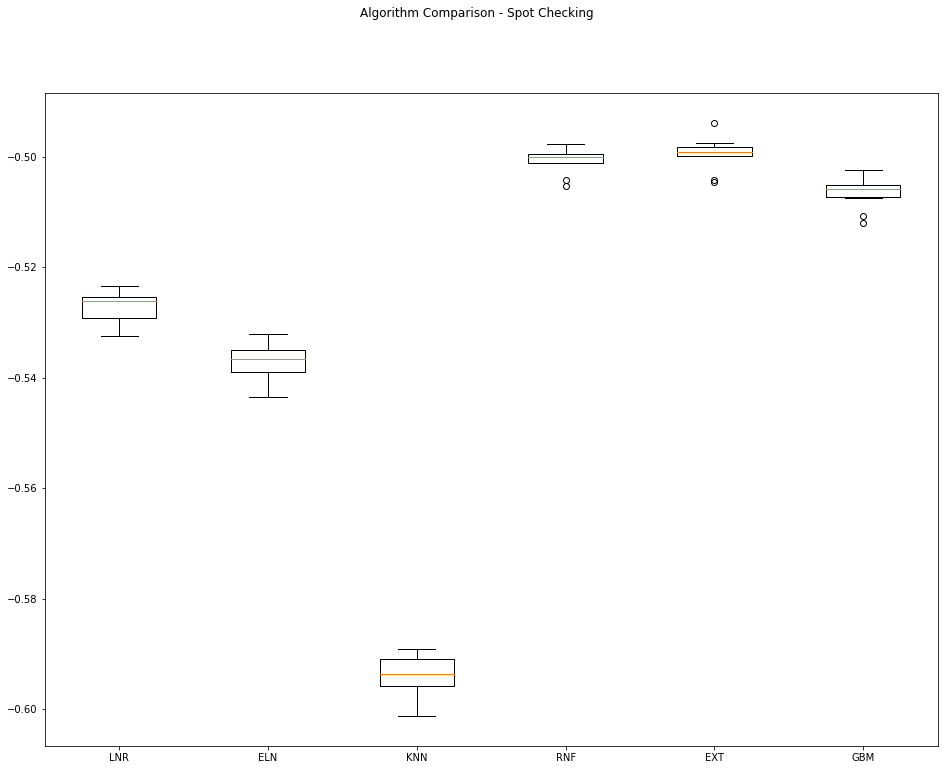

In [43]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [44]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [45]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [46]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [47]:
# Tuning algorithm #1 - Extra Trees
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = ElasticNet(random_state=RNG_SEED)
paramGrid1 = dict(l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]))
tune_model_names.append('ELN')

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result1.best_score_*-1)))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best: -0.537394 using {'l1_ratio': 0.1}
-0.537394 (0.003436) with: {'l1_ratio': 0.1}
-0.537394 (0.003436) with: {'l1_ratio': 0.5}
-0.537394 (0.003436) with: {'l1_ratio': 0.7}
-0.537394 (0.003436) with: {'l1_ratio': 0.9}
-0.537394 (0.003436) with: {'l1_ratio': 0.95}
-0.537394 (0.003436) with: {'l1_ratio': 0.99}
-0.537394 (0.003436) with: {'l1_ratio': 1.0}
Best RMSE for the Model is: 0.733071525992422
Model training time: 0:00:05.960271


In [48]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: l1_ratio = 0.1


In [49]:
# Tuning algorithm #2 - Gradient Boosting
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model_names.append('EXT')
tune_model2 = ExtraTreesRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)
paramGrid2 = dict(n_estimators=np.array([50, 100, 250, 400, 500]))

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result2.best_score_*-1)))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best: -0.494952 using {'n_estimators': 500}
-0.504681 (0.002795) with: {'n_estimators': 50}
-0.499464 (0.002949) with: {'n_estimators': 100}
-0.496121 (0.002851) with: {'n_estimators': 250}
-0.495204 (0.002695) with: {'n_estimators': 400}
-0.494952 (0.002733) with: {'n_estimators': 500}
Best RMSE for the Model is: 0.7035284978076433
Model training time: 3:27:34.668265


In [50]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 500


### 5.b) Compare Algorithms After Tuning

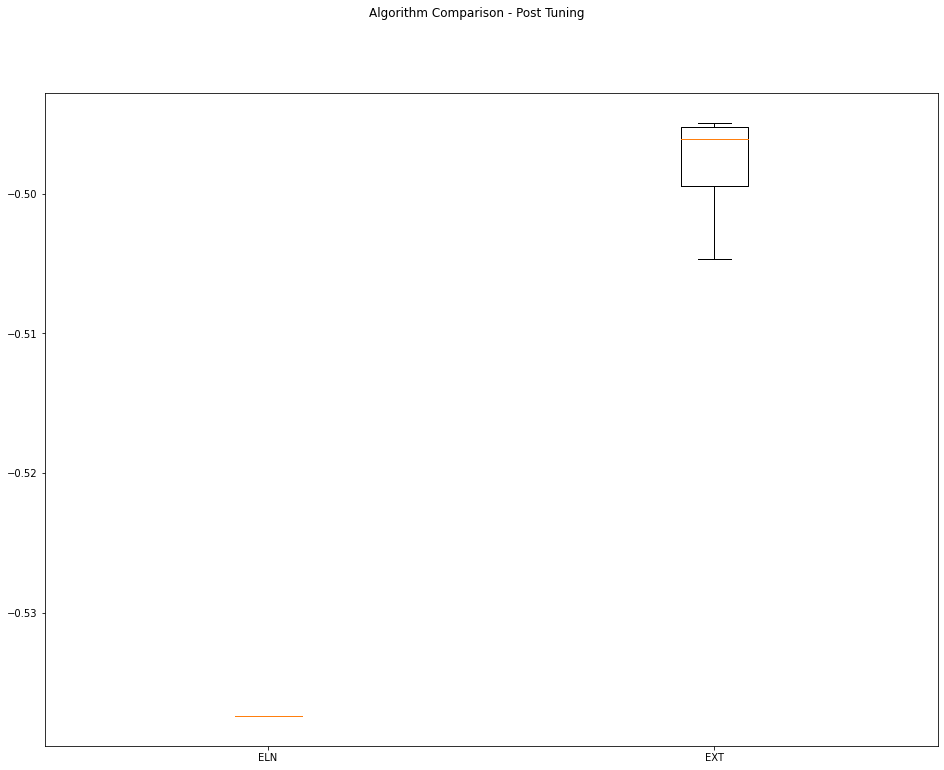

In [51]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [52]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [53]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [54]:
final_model = ExtraTreesRegressor(n_estimators=500, random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

ExtraTreesRegressor(n_estimators=500, n_jobs=2, random_state=888)


### 6.b) Load Test Dataset and Prepare the Submission File

In [55]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jan/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   id     cont1     cont2     cont3     cont4     cont5     cont6     cont7     cont8     cont9    cont10    cont11    cont12    cont13  \
0   0  0.353600  0.738780  0.600939  0.293377  0.285691  0.458006  0.620704  0.422249  0.369203  0.435727  0.550540  0.699134  0.286864   
1   2  0.907222  0.189756  0.215531  0.869915  0.301333  0.528958  0.390351  0.521112  0.794779  0.798580  0.446475  0.449037  0.916964   
2   6  0.179287  0.355353  0.623972  0.437812  0.282476  0.320826  0.386789  0.776422  0.222268  0.229102  0.211913  0.222651  0.327164   
3   7  0.359385  0.181049  0.551368  0.206386  0.280763  0.482076  0.506677  0.362793  0.379737  0.345686  0.445276  0.518485  0.299028   
4  10  0.335791  0.682607  0.676481  0.219465  0.282861  0.581721  0.748639  0.350158  0.448915  0.506878  0.817721  0.805895  0.790591   

     cont14  
0  0.364515  
1  0.513002  
2  0.827941  
3  0.598166  
4  0.249275  


In [56]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

   id
0   0
1   2
2   6
3   7
4  10


In [57]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

      cont1     cont2     cont3     cont4     cont5     cont6     cont7     cont8     cont9    cont10    cont11    cont12    cont13  \
0  0.353600  0.738780  0.600939  0.293377  0.285691  0.458006  0.620704  0.422249  0.369203  0.435727  0.550540  0.699134  0.286864   
1  0.907222  0.189756  0.215531  0.869915  0.301333  0.528958  0.390351  0.521112  0.794779  0.798580  0.446475  0.449037  0.916964   
2  0.179287  0.355353  0.623972  0.437812  0.282476  0.320826  0.386789  0.776422  0.222268  0.229102  0.211913  0.222651  0.327164   
3  0.359385  0.181049  0.551368  0.206386  0.280763  0.482076  0.506677  0.362793  0.379737  0.345686  0.445276  0.518485  0.299028   
4  0.335791  0.682607  0.676481  0.219465  0.282861  0.581721  0.748639  0.350158  0.448915  0.506878  0.817721  0.805895  0.790591   

     cont14  
0  0.364515  
1  0.513002  
2  0.827941  
3  0.598166  
4  0.249275  


In [58]:
# Finalize the test dataset for the modeling testing
array_features_test = df_features_test.to_numpy()
print("array_features_test.shape: {}".format(array_features_test.shape))

array_features_test.shape: (200000, 14)


In [59]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[8.01331661 7.82149098 7.94356827 ... 8.2685866  7.96669739 7.84082922]


In [60]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

   id    target
0   0  8.013317
1   2  7.821491
2   6  7.943568
3   7  8.159857
4  10  8.028802


In [61]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20210517-1942.csv


In [62]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [63]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 5:50:33.018106
